In [1]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn
import numpy as np
import pickle
import time
import os
import scipy.interpolate as spi

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
# plt.figure(figsize=(12,7))
# x = np.linspace(1,200,1000)
# plt.plot(x, compute_health_delta(x), label=r"$\epsilon(h)$")
# plt.plot(x, compute_health_cost(x), label=r"$c(h)$")
# plt.xlabel(r"$h$")
# plt.legend(shadow=True)
# plt.yticks(np.arange(1,11))
# plt.savefig("health_cost_delta.pdf", bbox_inches="tight")
# plt.show()

In [3]:
problem = {
    'num_vars': 7,
    'names': ["alpha", "prob_health_decrease", "prob_health_increase", "gamma", "w_delta_scale", "omega", "eta"],
    'bounds': [[0,1], [0,1], [0,1], [0.4,0.8], [0,1]]
}

In [4]:
result_suffix = "5"

### Sen's Welfare Function

In [5]:
def gini(data):
    if len(data) == 0:
        return 0
    data = np.asarray(data)
    data = np.sort(data)
    n = len(data)
    index = np.arange(1, n + 1)  # 1-based index
    gini = (2 * np.sum(index * data)) / (n * np.sum(data)) - (n + 1) / n
    return gini

def sen_welfare(data):
    return np.mean(data) * (1-gini(data))

In [6]:
result_dir = "results_" + result_suffix
sen_results = []

for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])
    sen_results.append(
        (res["params"], sen_welfare(util[:,-1]))
    )

with open(f"sen_welfare_{result_suffix}.pickle", "wb") as f:
    pickle.dump(sen_results, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [7]:
with open(f"sen_welfare_{result_suffix}.pickle", "rb") as f:
    sen_results = pickle.load(f)

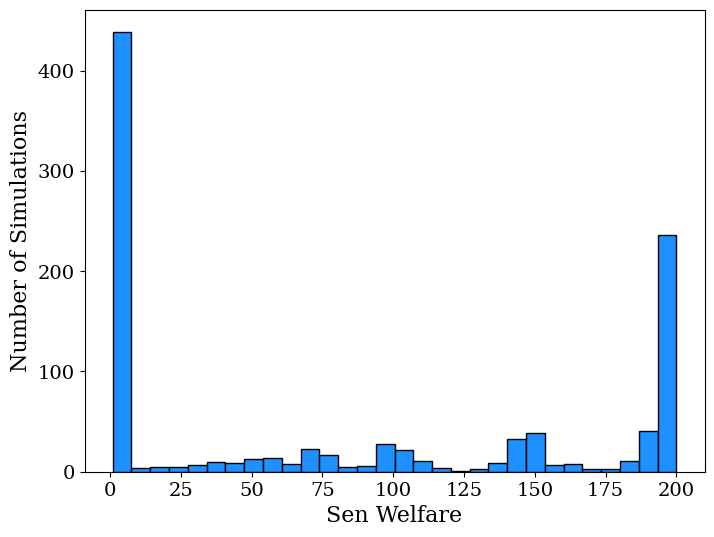

In [8]:
plt.hist(
    [t[1] for t in sen_results],
    bins=30,
    color="dodgerblue",
    edgecolor="k"
)
plt.xlabel("Sen Welfare")
plt.ylabel("Number of Simulations")
plt.show()

In [9]:
X = []
Y = []
for t in sen_results:
    X.append((t[0]["alpha"], t[0]["P_H_decrease"], t[0]["P_H_increase"], t[0]["gamma"], t[0]["w_delta_scale"], t[0]["gamma"], t[0]["eta"]))
    Y.append(t[1])
X = np.array(X)
Y = np.array(Y)


sen_pawn = pawn.analyze(problem, X, Y, S=10, print_to_console=False)
print(sen_pawn["mean"])

[0.41692621 0.09956619 0.10389998 0.09580917 0.17478137 0.09580917
 0.08393561]


/Users/charlesdupont/Documents/code/wealth-health/.venv/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


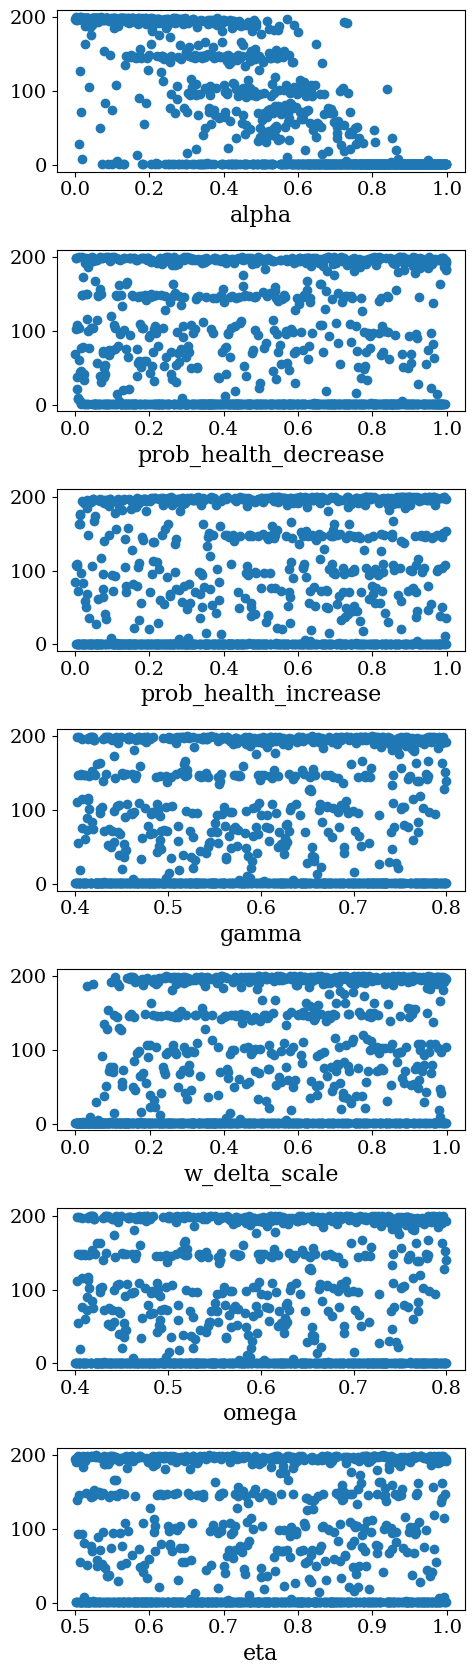

In [10]:
num_vars = problem["num_vars"]
fig, axs = plt.subplots(num_vars, 1, figsize=(5,17))
for idx in range(num_vars):
    axs[idx].scatter(
        X[:,idx],
        Y,
    )
    axs[idx].set_xlabel(problem["names"][idx])
fig.tight_layout()
plt.show()

### MFPT

In [11]:
def random_walk(n_steps, start_pos, step_size, interpolate, alpha, exp_factor=1):
    rand_nums = np.random.uniform(0, 1, size=(n_steps,))
    rand_angle = np.random.uniform(0, 2 * np.pi, size=(n_steps,))

    X = np.zeros((n_steps+1,))
    X[0] = start_pos[0]
    Y = np.zeros((n_steps+1,))
    Y[0] = start_pos[1]
    util = np.zeros((n_steps+1,))
    util[0] = utility(X[0], Y[0], alpha)
    current_potential = interpolate(X[0], Y[0])

    for step in range(n_steps):
        dx = np.cos(rand_angle[step]) * step_size
        dy = np.sin(rand_angle[step]) * step_size

        new_x = max(1, min(X[step] + dx, 200))
        new_y = max(1, min(Y[step] + dy, 200))        
        new_potential = interpolate(new_x, new_y, grid=False)

        # check whether to accept or reject moves
        accept = False
        if (new_potential < current_potential) or rand_nums[step] < exp_factor * np.exp(current_potential - new_potential):
            accept = True        
            current_potential = new_potential
            X[step+1] = new_x
            Y[step+1] = new_y
        else:
            X[step+1] = X[step]
            Y[step+1] = Y[step]
        
        util[step+1] = utility(X[step+1], Y[step+1], alpha)

    return util, X, Y

In [12]:
result_dir = "results_" + result_suffix

interpolation_functions = []
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    interp_func = get_interpolation_function(
        res["wealth"][:,-1],
        res["health"][:,-1]
    )
    interpolation_functions.append(
        (res["params"], interp_func)
    )

with open(f"interpolation_functions_{result_suffix}.pickle", "wb") as f:
    pickle.dump(interpolation_functions, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [13]:
with open(f"interpolation_functions_{result_suffix}.pickle", "rb") as f:
    interpolation_functions = pickle.load(f)

In [14]:
MINIMA = []
for param_set, func in tqdm(interpolation_functions):
    MINIMA.append(
        (param_set, get_minima(func, count_threshold=2, num_points=15, N=param_set["N"], step_size=10))
    )

with open(f"minima_{result_suffix}.pickle", "wb") as f:
    pickle.dump(MINIMA, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [15]:
with open(f"minima_{result_suffix}.pickle", "rb") as f:
    MINIMA = pickle.load(f)

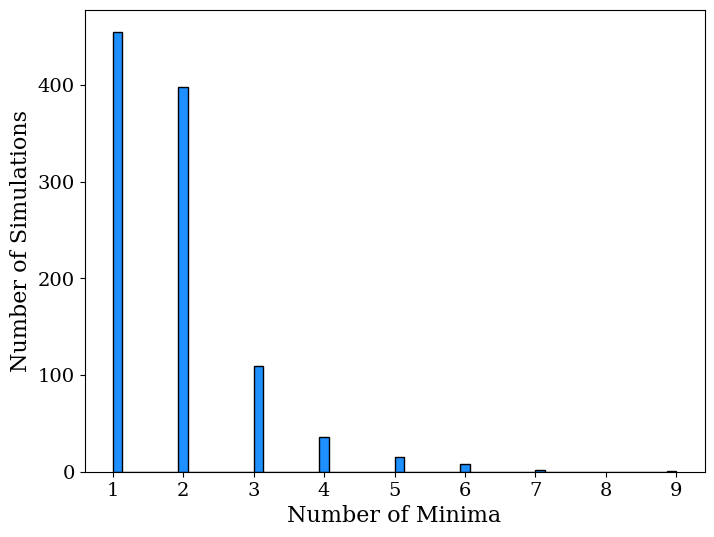

In [16]:
plt.hist(
    [len(m[1]) for m in MINIMA],
    bins=60,
    color="dodgerblue",
    edgecolor="k"
)
plt.xlabel("Number of Minima")
plt.ylabel("Number of Simulations")
plt.show()

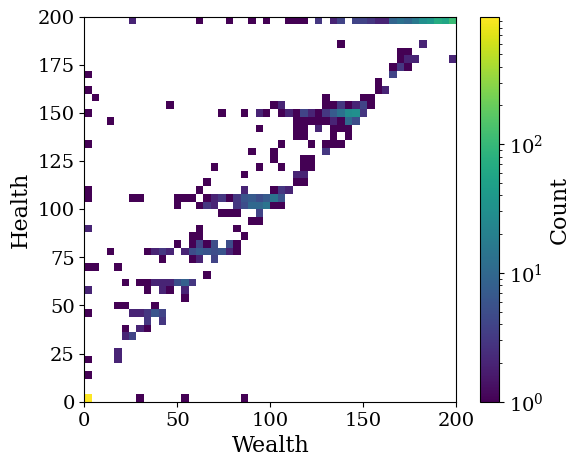

In [17]:
minima_locations = []
for m in MINIMA:
    for point in m[1]:
        minima_locations.append(point[0])

plt.figure(figsize=(6,5))
hist = plt.hist2d(
    [x[0] for x in minima_locations],
    [x[1] for x in minima_locations],
    bins=50,
    norm="log"
)

plt.colorbar(hist[3], label="Count")

plt.xlabel("Wealth")
plt.ylabel("Health")
plt.savefig("minima_locations.pdf", bbox_inches="tight")
plt.show()

In [18]:
all_utils = []
for simulation_idx, item in tqdm(enumerate(MINIMA)):
    params, minima_list = item
    util_diffs = []
    for i in range(len(minima_list)):
        if minima_list[i][1] <= 2:
            continue
        w_i, h_i = minima_list[i][0]
        util, x, y = random_walk(100, (w_i,h_i), 1, interpolation_functions[simulation_idx][1], params["alpha"], exp_factor=0.5)
        util_diffs.append(util.max() - util[0])
    all_utils.append(
        (
            params,
            np.mean(util_diffs)
        )
    )

0it [00:00, ?it/s]

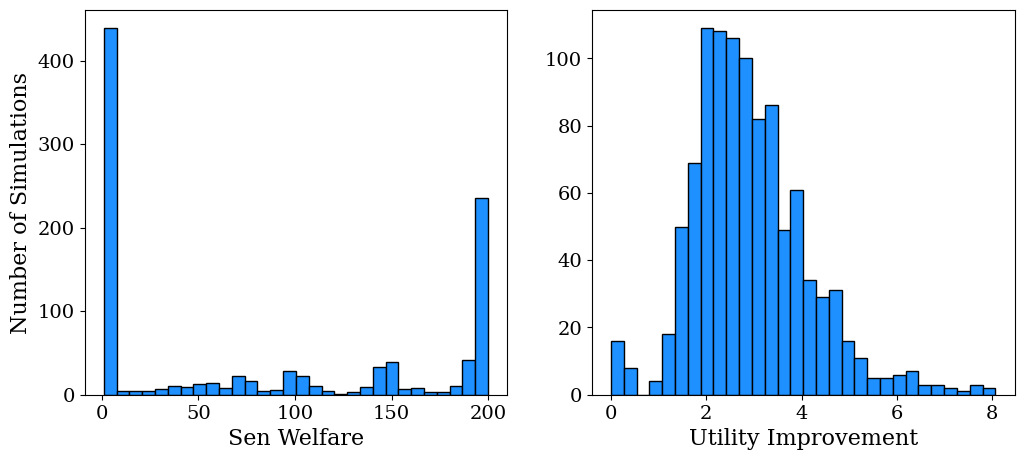

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].hist(
    [t[1] for t in sen_results],
    bins=30,
    color="dodgerblue",
    edgecolor="k"
)
axs[0].set_xlabel("Sen Welfare")
axs[0].set_ylabel("Number of Simulations")

axs[1].hist(
    [x[1] for x in all_utils],
    color="dodgerblue",
    edgecolor="k",
    bins=30
)
axs[1].set_xlabel("Utility Improvement")

plt.savefig("gsa_distributions.pdf", bbox_inches="tight")

plt.show()

In [20]:
X = []
Y = []
for t in all_utils:
    X.append((t[0]["alpha"], t[0]["P_H_decrease"], t[0]["P_H_increase"], t[0]["gamma"], t[0]["w_delta_scale"], t[0]["gamma"], t[0]["eta"]))
    Y.append(t[1])
X = np.array(X)
Y = np.array(Y)

util_improvement_pawn = pawn.analyze(problem, X, Y, S=10, print_to_console=False)
util_improvement_pawn["mean"]

/Users/charlesdupont/Documents/code/wealth-health/.venv/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


array([0.28160727, 0.09628494, 0.08982912, 0.07297649, 0.14437948,
       0.07297649, 0.07929174])

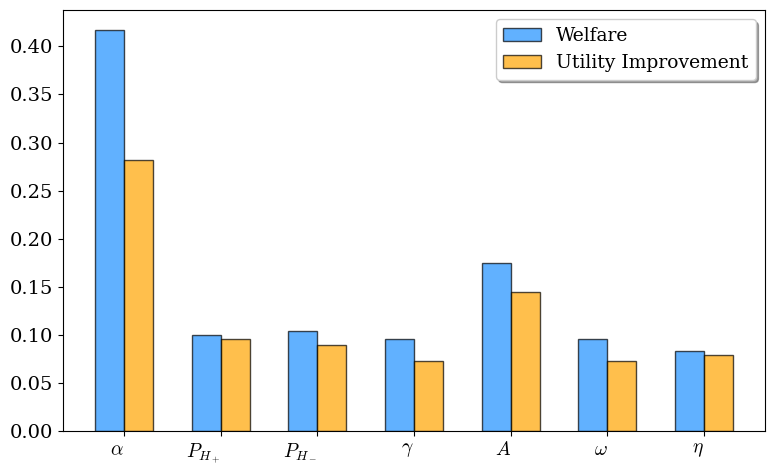

In [21]:
# Categories on x-axis
categories = [r'$\alpha$', r'$P_{H_+}$', r'$P_{H_-}$', r'$\gamma$', r'$A$', r'$\omega$', r'$\eta$']

# Data for the bars
sen_values = sen_pawn["mean"]
util_values = util_improvement_pawn["mean"]

# X locations for the groups
x = np.arange(len(categories))

# Width of bars
width = 0.3  

# Create bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, sen_values, width, label='Welfare', color='dodgerblue', alpha=0.7, edgecolor="k")
ax.bar(x + width/2, util_values, width, label='Utility Improvement', color='orange', alpha=0.7, edgecolor="k")

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(categories, ha="right")
ax.legend(shadow=True)

# Show plot
plt.tight_layout()
plt.savefig("pawn_sensitivity_indices.pdf", bbox_inches="tight")
plt.show()

### Investigate final state space outcome as function of initial state

In [45]:
init_w = []
init_h = []

result_dir = "results_" + result_suffix
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    condition = (wealth[:,-1] <=5) & (health[:,-1] <=5)
    init_w.append(wealth[condition,0])
    init_h.append(health[condition,0])

init_w = np.concatenate(init_w)
init_h = np.concatenate(init_h)

  0%|          | 0/1024 [00:00<?, ?it/s]

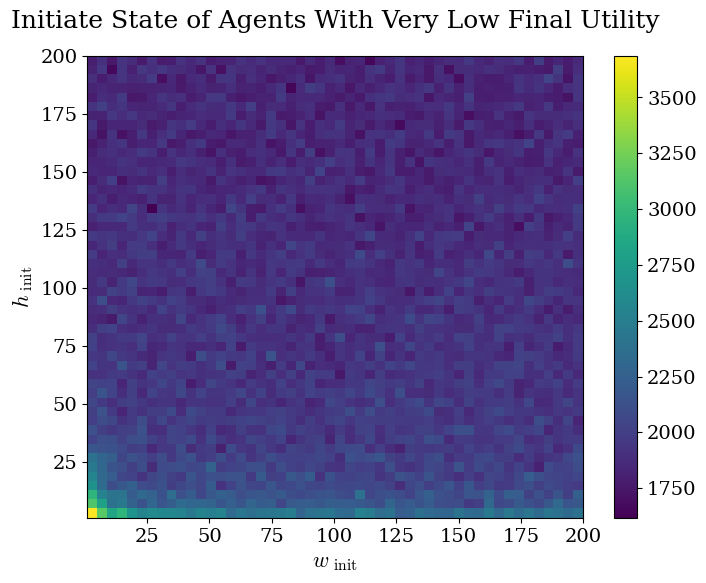

In [46]:
fig, ax = plt.subplots()
h = ax.hist2d(init_w, init_h, bins=50)
fig.colorbar(h[3], ax=ax)
plt.xlabel(r"$w_{\text{ init}}$")
plt.ylabel(r"$h_{\text{ init}}$")
plt.title("Initiate State of Agents With Very Low Final Utility", pad=20)
plt.show()